In [1]:
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
from matplotlib import pyplot as plt

In [2]:
seed=24
batch_size= 8

img_data_gen_args = dict(rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect',
                      preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 


image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/512x512_train/image'), 
                                                           seed=seed, 
                                                           batch_size=batch_size,
                                                           class_mode=None)  #Very important to set this otherwise it returns multiple numpy arrays 
                                                                            #thinking class mode is binary.

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/512x512_train/mask'), 
                                                         seed=seed, 
                                                         batch_size=batch_size,
                                                         color_mode = 'grayscale',   #Read masks in grayscale
                                                         class_mode=None)


valid_img_generator = image_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/512x512_validation/image'), 
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               class_mode=None)

valid_mask_generator = mask_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/512x512_validation/mask'), 
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)

train_generator = zip(image_generator, mask_generator)
val_generator = zip(valid_img_generator, valid_mask_generator)

Found 7000 images belonging to 1 classes.
Found 7000 images belonging to 1 classes.
Found 1500 images belonging to 1 classes.
Found 1500 images belonging to 1 classes.


In [3]:
num_train_imgs = len(os.listdir(os.path.normpath('dataset/MapAI/512x512_train/image/train')))
steps_per_epoch = num_train_imgs // batch_size
print(steps_per_epoch)

875


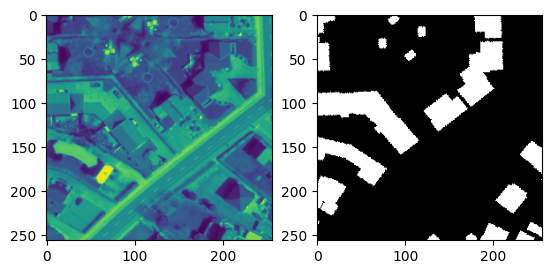

In [9]:
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0])
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0], cmap='gray')
    plt.show()